In [1]:
'''
Author: Philipp Joppich
Master's Thesis: Bayesian Inference with Neural Networks: Reconstruction and Classification of Corrupted Data
Code to reproduce results displayed in my thesis. 
For questions, please contact me via philipp@joppich.com

Software from various developers is used in this algorithm. Only code that is not implemented 
in a publicly available library is specifically pointed out. Respective sections are marked
with the following indices:

[1] Knollmüller, Jakob (Max-Planck Institut für Astrophysik): TensorFlowOperator 
[2] ImportanceOfBeingErnest [https://stackoverflow.com/users/4124317/importanceofbeingernest]: Random Mask
[3] Salehi, Ali [https://github.com/alisaaalehi]: Convolution formulated as Matrix Multiplication
[4] Bhobeé, Manish, https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e: Cutting out Validation Set from Training Data

Moreover, the following libraries are used:
[1] NIFTy – Numerical Information Field Theory, https://gitlab.mpcdf.mpg.de/ift/nifty
[2] NumPy - Numerical Python, https://numpy.org/
[3] Tensorflow - Tensorflow, https://www.tensorflow.org/
[4] Keras - Keras, https://keras.io/
[5] Matplotlib - Matplotlib, https://matplotlib.org/
[6] SciPy - Scientific Python, https://www.scipy.org/
[7] random - random, https://docs.python.org/3/library/random.html
[8] sklearn - https://scikit-learn.org/
[9] scipy - Science Python, https://www.scipy.org/


All Neural Networks were built with Keras and saved as a tensorflow-object. Neural Netowrks are optimized for MNIST, good performance is observed for
F-MNIST, CIFAR-10 performs moderatly and needs further refinement.

This code is written with Google Colab.
'''


"\nAuthor: Philipp Joppich\nMaster's Thesis: Bayesian Inference with Neural Networks: Reconstruction and Classification of Corrupted Data\nCode to reproduce results displayed in my thesis. \nFor questions, please contact me via philipp@joppich.com\n\nSoftware from various developers is used in this algorithm. Only code that is not implemented \nin a publicly available library is specifically pointed out. Respective sections are marked\nwith the following indices:\n\n[1] Knollmüller, Jakob (Max-Planck Institut für Astrophysik): TensorFlowOperator \n[2] ImportanceOfBeingErnest [https://stackoverflow.com/users/4124317/importanceofbeingernest]: Random Mask\n[3] Salehi, Ali [https://github.com/alisaaalehi]: Convolution formulated as Matrix Multiplication\n[4] Bhobeé, Manish, https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e: Cutting out Validation Set from Training Data\n\nMoreover, the following libraries are used:\n[1] NIFTy – Numerical Information Field Theo

In [2]:
# Colab and system related
import os
import time
from google.colab import drive
import sys
drive.mount('/content/drive')
from google.colab import output
#Nifty
if os.path.isdir('nifty') == False:
    !git clone https://gitlab.mpcdf.mpg.de/ift/nifty.git
sys.path.append('/content/nifty')
import nifty6 as ift
sys.path.append('/content/drive/My Drive/masterthesis/github/')

###
# [1]
# Necessary to convert tensorflow-object (e.g. Neural Network) to Nifty-Operator
from operators.tensorflow_operator import TensorFlowOperator
###

# Include path to access helper functions and Mask / Conv Operator (Google-Colab specific syntax)
sys.path.append('/content/drive/My Drive/masterthesis/github/helper_functions/')
from helper_functions import clear_axis, gaussian, get_cmap, info_text, get_noise, rotation, split_validation_set, dropout_uncertainty
import Mask # Masking Operator
import Conv # Convolution Operator

# Tensorflow
import tensorflow as tf

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

# Google-Colab specific syntax to adjust figure size (may be excluded)
%matplotlib inline
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 9.0

# Numerics
import random
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import decomposition

import scipy
from astropy.convolution import RickerWavelet2DKernel
from scipy.signal import convolve as scipy_convolve

Mounted at /content/drive
Cloning into 'nifty'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 39185 (delta 129), reused 155 (delta 101), pack-reused 38991
Receiving objects: 100% (39185/39185), 15.20 MiB | 4.98 MiB/s, done.
Resolving deltas: 100% (29820/29820), done.
Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Choose dataset
dataset = 'mnist' #'mnist, 'fashion-mnist'
datasource = getattr(tf.keras.datasets, dataset)
(XTrain, YTrain), (XTest, YTest) = datasource.load_data()
XTrain, XTest = XTrain / 255.0, XTest / 255.0

x_shape = XTrain[1].shape[0]
y_shape = XTrain[1].shape[1]
try:
  z_shape = XTrain[1].shape[2]
  img_shape = [x_shape, y_shape, z_shape]
except:
    img_shape = [x_shape, y_shape]

xy_shape = x_shape * y_shape
flattened_shape = np.prod(img_shape)
# Reshape Xtrain and XTest to flattened Vectors instead of square arrays
if dataset == 'mnist' or dataset== 'fashion_mnist':
  XTrain = XTrain.reshape((len(XTrain), np.prod(XTrain.shape[1:])))
  XTest = XTest.reshape((len(XTest), np.prod(XTest.shape[1:])))

n_classes = len(np.unique(YTrain))

# Session for tensorflow v1 compatibility
sess = tf.compat.v1.InteractiveSession()
graph = tf.compat.v1.get_default_graph()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
###
# [4]
###
# Split Training-Dataset into additional validation set.
XTrain, YTrain, XVal, YVal = split_validation_set(XTrain, YTrain, val_perc=0.2)

In [5]:
# Read in model#
######## Path needs to be adjusted according to the location of NN! ########
if dataset=='mnist': 
  Decoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/MNIST/pretrained_unsupervised_ae10/Decoder/', compile=False)
  Encoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/MNIST/pretrained_unsupervised_ae10/Encoder', compile=False)

  Decoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/MNIST/pretrained_supervised_ae10/Decoder', compile=False)
  Encoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/MNIST/pretrained_supervised_ae10/Encoder', compile=False)
                  
  #Decoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/MNIST/pretrained_semi_supervised_ae10/Decoder', compile=False)
  #Encoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/MNIST/pretrained_semi_supervised_ae10/Encoder', compile=False)

  #Decoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/MNIST/pretrained_unsupervised_ae64/Decoder', compile=False)
  #Encoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/MNIST/pretrained_unsupervised_ae64/Encoder', compile=False)
if dataset=='fashion_mnist': 
  Decoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/Fashion-MNIST/pretrained_unsupervised_ae10/Decoder', compile=False)
  Encoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/Fashion-MNIST/pretrained_unsupervised_ae10/Encoder', compile=False)

  Decoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/Fashion-MNIST/pretrained_supervised_ae10/Decoder', compile=False)
  Encoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/Fashion-MNIST/pretrained_supervised_ae10/Encoder', compile=False)
if dataset=='cifar10': 
  Decoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/CIFAR10/pretrained_semi_supervised_ae/Decoder', compile=False)
  Encoder_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/CIFAR10/pretrained_semi_supervised_ae/Encoder', compile=False)

# Read in Classifier
Classifier_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/MNIST/pretrained_classifier/Classifier', compile=False)
#Classifier_tf = tf.keras.models.load_model('drive/My Drive/masterthesis/github/NNs/CIFAR10/pretrained_semi_supervised_ae/Encoder', compile=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# Define ift-space
# position_space: Also data-space. Equal to the vectorized image dimension. For MNIST-Images, the position-space's
# dimensions are 784x1
position_space = ift.UnstructuredDomain(Decoder_tf.get_layer(index=-1).output_shape[1:])

# n_latent: number of latent space activations
n_latent = Encoder_tf.get_layer(index=-1).output_shape[-1]
# latent_space: Domain with dimensions of the latent space
latent_space = ift.UnstructuredDomain([n_latent])

# Initialize Parameters
# Pre-Defined parameters by Max-Planck-Institute
comm, _, _, master = ift.utilities.get_MPI_params()

# Convert Encoder and Decoder to nifty-operators (``TensorFlowOperator``)
Decoder = TensorFlowOperator(Decoder_tf.layers[-1].output, Decoder_tf.layers[0].output, latent_space, position_space)
Encoder = TensorFlowOperator(Encoder_tf.layers[-1].output, Encoder_tf.layers[0].output, position_space, latent_space)

# Choose how to classify data, once it has been reconstructed.
Classifier = Encoder
#Classifier = TensorFlowOperator(Classifier_tf.layers[-2].output, Classifier_tf.layers[0].output, position_space,ift.UnstructuredDomain(n_classes))

In [7]:
# Get all activations in the latent space from Encoder with Validation Dataset -> latent_values
latent_values = np.zeros((len(XVal), n_latent))
for i, pic in enumerate(XVal):
  pic = np.reshape(pic, position_space.shape)
  latent_values[i, :] = Encoder(ift.Field.from_raw(position_space, pic)).val  

# Fill means-array with mean activation of every picture
means = np.zeros([n_latent, n_classes])
for pic in range(n_classes):
  for weight in range(n_latent):
    means[weight, pic] = np.mean(latent_values[np.where(YVal == pic), weight])

# Define overall mean of all activations in latent-space
mean = ift.Field.from_raw(latent_space, np.mean(latent_values, axis=0)) #mean of all activations in latent
Mean = ift.Adder(mean)

# Fill cov_all_variables with covariances of activation of every digit;
# Get cov_supervised_variables with covariances of only supervised activations
cov_all_variables = [[np.zeros([n_latent, n_latent])] for y in range(n_classes)]
cov_supervised_variables = [[np.zeros([n_classes, n_classes])] for y in range(n_classes)]

for i in range(n_classes):
  cov_all_variables[i] = np.cov(latent_values[np.where(YVal==i)[0]][:,:], rowvar=False)
  cov_supervised_variables[i] = np.cov(latent_values[np.where(YVal==i)[0]][:,:10], rowvar=False)

# Fill overall covariance of all activations in latent space
cov = np.zeros([n_latent, n_latent])
cov = np.cov(latent_values, rowvar=False)

# Transform covariance matrix into standardized space by Cholesky factorization
# cov = AA^T
A = ift.MatrixProductOperator(ift.UnstructuredDomain([n_latent]), np.linalg.cholesky(cov))

In [8]:
''' 
Generate Ground Truth either 
    --> from Sampling from latent distribution OR
    --> from drawing a sample from independent partition of dataset
'''
## Sampling from latent distribution
#xi = ift.from_random(latent_space, 'normal')
#s = A.apply(xi, 1) + mean
#ground_truth = Decoder(s)

## Drawing sample from dataset
p=3
#p = 10
ground_truth = ift.Field.from_raw(position_space, np.reshape(XTest[p], position_space.shape))

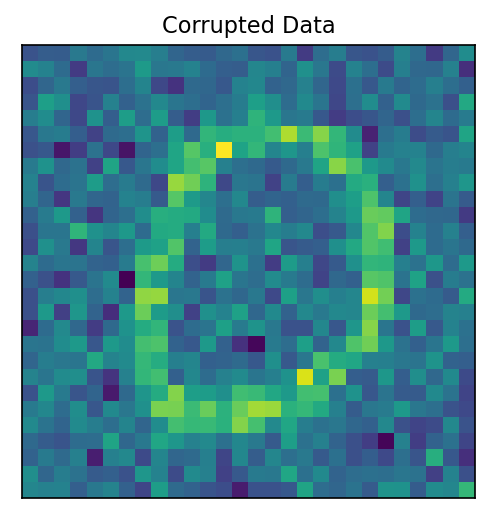

In [9]:
'''
Data Corruption:

1. Mask --> Operator: M (no_mask, half_mask, corner_mask, checkerboard_mask, random_mask)
2. Noise --> Operator: N 
3. Convolution --> Operator: C (sobel, gaussian_blur, edge_detection, own)

Data Modification (not included in modeling-process; thus the Model "does not 
know" these modifications):

4. Rotation (angle)

X. Response --> Operator: R (Concatenated Mask, Noise and Convolution)
'''
p = 10 # Specify element of XTest that is to be corrupted and to be evaluated; can be arbitrary integer within length of XTest

ground_truth = ift.Field.from_raw(position_space, np.reshape(XTest[p], position_space.shape))
# 1. Mask
M = Mask.no_mask(position_space=position_space)
#M = Mask.half_mask(position_space=position_space, mask_range=0.5)
#M = Mask.random_mask(position_space=position_space, seed=10, n_blobs=25)

# 2. Noise
N, n = get_noise(noise_level=0.1, position_space=position_space, seed=10)

# 3. Convolution
C = Conv.gaussian_blur(5, 1, position_space=position_space) # sobel, edge_detection, 

# 4. Rotation (not included in data-model, reconstruction may be poor!)
# Specify angle in degrees (clockwise rotation)
ground_truth_rot = rotation(ground_truth, img_shape, angle=0)

# Apply Data Corruption to Ground Truth and creeate Response operator

GR = ift.GeometryRemover(position_space)
R = GR(M) # Without Convolution
#R = GR(M @ C) # With Convolution
data = R((ground_truth_rot))+n # Apply Response R on (rotated) ground truth --> Noise is applicated after masking

plt.imshow(np.reshape(data.val, img_shape))
plt.title('Corrupted Data')
clear_axis()
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 9.0
plt.show()

In [10]:
# Define Hyperparameters for minimizer via Iteration-Controllers
# These Hyperparameters are not fully optimized!

ic_sampling = ift.AbsDeltaEnergyController(name='Sampling', deltaE=1e-2, iteration_limit=150)
ic_newton = ift.AbsDeltaEnergyController(name='Newton', deltaE=5e-2, iteration_limit=150)
minimizer = ift.NewtonCG(ic_newton)

In [11]:
'''
Define Likelihood as Gaussian Energy
mean: data (corruped image with R applied)
inverse_covariance: Inverse of Noise-Matrix N
R: Response Operator
Decoder: Generator mapping data from latent space to image space
Mean: Adder Operator; Mean of all latent Space activations
A: Product Operator; Transformed Covariance of all latent space activations

Mean and A originate from the following transformation: 
s = A*xi+Mean

'''
likelihood = ift.GaussianEnergy(mean=data, inverse_covariance=N.inverse) @ R @ Decoder @ Mean @ A
H = ift.StandardHamiltonian(likelihood, ic_sampling)

In [12]:
# Run MGKL
n_samples = 50 # Define number of samples with which posterior distribution is approximated; the more samples --> higher runtime, higher accuracy

def MGKL(n_samples, H):
    initial_mean = ift.Field.full(latent_space, 0.) # Define initial activation; random initialization works as well
    mu = initial_mean
    for i in range(5): 
      # Draw new samples and minimize KL
      KL = ift.MetricGaussianKL(mu, H, n_samples, mirror_samples=False) # Set up KL with current mu
      output.clear()
      KL, convergence = minimizer(KL) # Minimize KL and check for convergence
      mu = KL.position # Set minimized KL as new mu
      output.clear()
    n_samples=n_samples
    KL = ift.MetricGaussianKL(mu, H, n_samples, mirror_samples=False)
    output.clear()
    KL, convergence = minimizer(KL)
    output.clear()
    return KL

iters=1 # Define number of iterations of posterior approximation. This might be helpful to check "how certain" the approximation is and if only an unstable local minimum is found
KL_iterations = []
for i in range(iters):
  KL_iterations.append(MGKL(n_samples, H))
n_samples=n_samples


In [13]:
# Draw inferred signal from posterior samples and transform to original space
sc = ift.StatCalculator()

for i in range(iters):
  KL = KL_iterations[i]
  for sample in KL.samples:
    sc.add(A.apply(sample + KL.position, 1) + mean) # Retransform signal s = A*xi+mu

posterior_mean = sc.mean # Get mean of all samples
posterior_std = ift.sqrt(sc.var) # Get standard deviation of all samples

In [14]:
# Classify posteriors via mahalanobis-distance and by classifying all posterior samples
# with seperatly trained network ('Classifier')
mahalanobis_distance_supervised = np.zeros([iters*n_samples, n_classes])
mahalanobis_distance = np.zeros([iters*n_samples, n_classes])
classified_posteriors = np.zeros([iters*n_samples, n_latent])
latent_posteriors = np.zeros([iters*n_samples, n_latent])

for k in range(iters):
  KL = KL_iterations[k]
  for j, sample in enumerate(KL.samples):
    s_posterior = A.apply(sample + KL.position, 1) + mean

    latent_posteriors[j+k*n_samples, :] = s_posterior.val
    classified_posteriors[j+k*n_samples, :] = Classifier(Decoder(s_posterior)).val
    for i in range(n_classes):
      mahalanobis_distance_supervised[j+k*n_samples, i] = np.sqrt((s_posterior.val[:n_classes] - means[:n_classes,i]).T @ np.linalg.inv(cov_supervised_variables[i]) @ (s_posterior.val[:n_classes] - means[:n_classes,i]))
      mahalanobis_distance[j+k*n_samples, i] = np.sqrt((s_posterior.val - means[:,i]).T @ np.linalg.inv(cov_all_variables[i]) @ (s_posterior.val - means[:,i]))
      #mahalanobis_distance[j+k*n_samples, i] = np.sqrt((s_posterior.val - means[:,i]).T @  (s_posterior.val - means[:,i])) # Euclidian Distance


mahalanobis_mean = np.mean(mahalanobis_distance, axis=0)
mahalanobis_std = np.sqrt(np.var(mahalanobis_distance, axis=0))

mahalanobis_mean_supervised = np.mean(mahalanobis_distance_supervised, axis=0)
mahalanobis_std_supervised = np.sqrt(np.var(mahalanobis_distance_supervised, axis=0))

classified_mean = np.mean(classified_posteriors, axis=0)
classified_std = np.std(classified_posteriors, axis=0)




In [15]:
# Get all classifications of posterior samples for pie-plot visualization

classified_posteriors_nn = np.sort(np.argmax(classified_posteriors, axis=1))
classified_posteriors_dm = np.sort(np.argmin(mahalanobis_distance, axis=1))
for i in range(n_classes):
  unique_digit_nn, count_nn = np.unique(classified_posteriors_nn, return_counts=True)
  unique_digit_dm, count_dm = np.unique(classified_posteriors_dm, return_counts=True)
counts_nn = dict(zip(unique_digit_nn, count_nn))
counts_dm = dict(zip(unique_digit_dm, count_dm))

viridis = cm.get_cmap('viridis', n_classes)
pie_colors = viridis(np.linspace(0, 1, n_classes))

In [16]:
# Create dictionary with important information:
# Top scores of respective classification method (M-Dist, NN)
# True or false classification (only valid if Labels given)
# Overlapping standard-deviations

n_scores = 3 # Number of top scoring elements to be displayed (max: n_classes)
top_scores_nn = list(reversed(np.argsort(classified_mean)[-n_scores:]))
top_scores_dm = list(np.argsort(mahalanobis_mean)[:n_scores])

overlap_bottom_nn = np.zeros(n_scores-1)
overlap_bottom_dm = np.zeros(n_scores-1)

for i in range(n_scores-1):
  overlap_bottom_nn[i] = (classified_mean[top_scores_nn[0]] - classified_std[top_scores_nn[0]]) - (classified_mean[top_scores_nn[i+1]] + classified_std[top_scores_nn[i+1]])
  overlap_bottom_dm[i] = (mahalanobis_mean[top_scores_dm[i+1]] - mahalanobis_std[top_scores_dm[i+1]]) - (mahalanobis_mean[top_scores_dm[0]] + mahalanobis_std[top_scores_dm[0]])


keys_nn = ['Measure','Top Scores:', 'Classification:', 'ID:', 'N Samples:']
keys_dm = ['Measure','Top Scores:', 'Classification:', 'ID:', 'N Samples:', 'M-Dist of {}:'.format(top_scores_dm[0])]


if top_scores_nn[0] == YTrain[-p]:
  values_nn = ['Neural Net Classifier','{}'.format(tuple(top_scores_nn)), 'True', 'YTrain[-{}]'.format(p), '{}'.format(n_samples)]

if top_scores_dm[0] == YTrain[-p]:
  values_dm = ['Mahalanobis Distance','{}'.format(tuple(top_scores_dm)), 'True', 'YTrain[-{}]'.format(p), '{}'.format(n_samples), '{}'.format(mahalanobis_mean[top_scores_dm[0]])]

if top_scores_nn[0] != YTrain[-p]:
  values_nn = ['Neural Net Classifier','{}'.format(tuple(top_scores_nn)), 'False', 'YTrain[-{}]'.format(p), '{}'.format(n_samples)]
if top_scores_dm[0] != YTrain[-p]:
  values_dm = ['Mahalanobis Distance','{}'.format(tuple(top_scores_dm)), 'False', 'YTrain[-{}]'.format(p), '{}'.format(n_samples), '{}'.format(mahalanobis_mean[top_scores_dm[0]])]


# Store Overlapping in Dictionary, expressed in terms of sigmas/STD of top Scoring digit

for i in range(n_scores - 1):
  keys_nn.append('Overlap [sigmas] {} --> {}'.format(top_scores_nn[0], top_scores_nn[i+1]))
  values_nn.append(overlap_bottom_nn[i] / classified_std[top_scores_nn[0]])
  keys_dm.append('Overlap [sigmas] {} --> {}'.format(top_scores_dm[0], top_scores_dm[i+1]))
  values_dm.append(overlap_bottom_dm[i] / mahalanobis_std[top_scores_dm[0]])

overlapping_nn = dict(zip(keys_nn, values_nn))
overlapping_dm = dict(zip(keys_dm, values_dm))

#np.save('drive/My Drive/masterthesis/results/temporary/{}-{}.npy'.format(p, overlapping_dm['Measure']), overlapping_dm) 
#np.save('drive/My Drive/masterthesis/results/temporary/{}-{}.npy'.format(p, overlapping_nn['Measure']), overlapping_nn) 

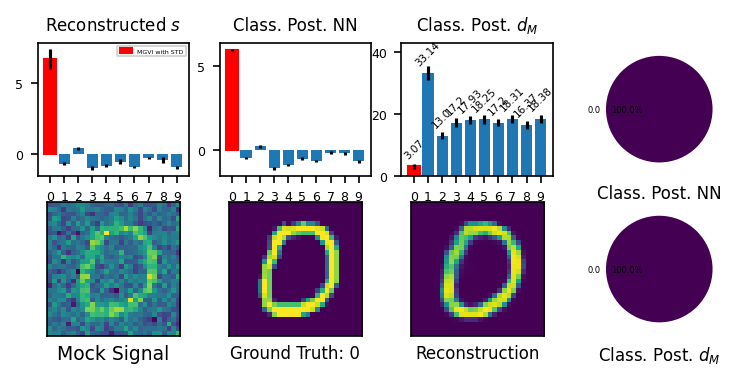

In [17]:
min = np.min([posterior_mean.val])
max = np.max([posterior_mean.val])

plt.subplot(3, 4, 1)
barplot = plt.bar(range(n_classes), posterior_mean.val[0:n_classes], alpha=1, width=0.8, yerr=posterior_std.val[0:n_classes], label='MGVI with STD')
barplot[np.where(posterior_mean.val == np.max(posterior_mean.val[:10]))[0][0]].set_color('r')
plt.legend(fontsize=3)
plt.title('Reconstructed $s$', fontsize=8)
plt.xticks(range(n_classes), fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(3, 4, 2)
barplot = plt.bar(range(n_classes), classified_mean[:10], yerr=classified_std[:10])
plt.xticks(np.arange(n_classes), fontsize=6)
plt.yticks(fontsize=6)

barplot[np.where(classified_mean == np.max(classified_mean))[0][0]].set_color('r')
plt.title('Class. Post. NN', fontsize=8)

plt.subplot(3, 4, 3)
m_mean = mahalanobis_mean_supervised
m_std = mahalanobis_std_supervised
barplot = plt.bar(range(n_classes), m_mean, yerr=m_std)
barplot[np.where(m_mean == np.min(m_mean))[0][0]].set_color('r')
for bar in barplot:
   yval = bar.get_height()
   yval = np.round(yval, decimals=2)
   plt.annotate('{}'.format(yval),
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=5, rotation=45)
plt.title('Class. Post. $d_M$', fontsize=8)
plt.ylim(0, 1.3*np.max(m_mean))
plt.xticks(np.arange(n_classes), fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(3, 4, 5)
plt.imshow(np.reshape(data.val, img_shape))
plt.xlabel('Mock Signal')
clear_axis()
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(3, 4, 6)
plt.imshow(np.reshape(ground_truth.val, img_shape))
plt.xlabel('Ground Truth: {}'.format(YTest[p]), fontsize=8)
clear_axis()

plt.subplot(3, 4, 7)
plt.imshow(np.reshape(Decoder(posterior_mean).val, img_shape))
plt.xlabel('Reconstruction', fontsize=8)
clear_axis()

plt.subplot(3, 4, 4)
plt.pie([float(v) for v in counts_nn.values()], labels=[float(k) for k in counts_nn.keys()],autopct='%1.1f%%', colors=pie_colors[list(counts_nn.keys())], textprops={'fontsize': 4} )
plt.xlabel('Class. Post. NN', fontsize=8)
plt.subplot(3, 4, 8)
plt.pie([float(v) for v in counts_dm.values()], labels=[float(k) for k in counts_dm.keys()],autopct='%1.1f%%', colors=pie_colors[list(counts_dm.keys())], textprops={'fontsize': 4})
plt.xlabel('Class. Post. $d_M$', fontsize=8)

plt.savefig('drive/My Drive/masterthesis/results/temporary/{}.png'.format(np.where(mahalanobis_distance == np.min(mahalanobis_distance))[0][0]))
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['font.size'] = 9.0
plt.show()

Text(0.5, 1.0, 'Reconstructed Posterior Mean')

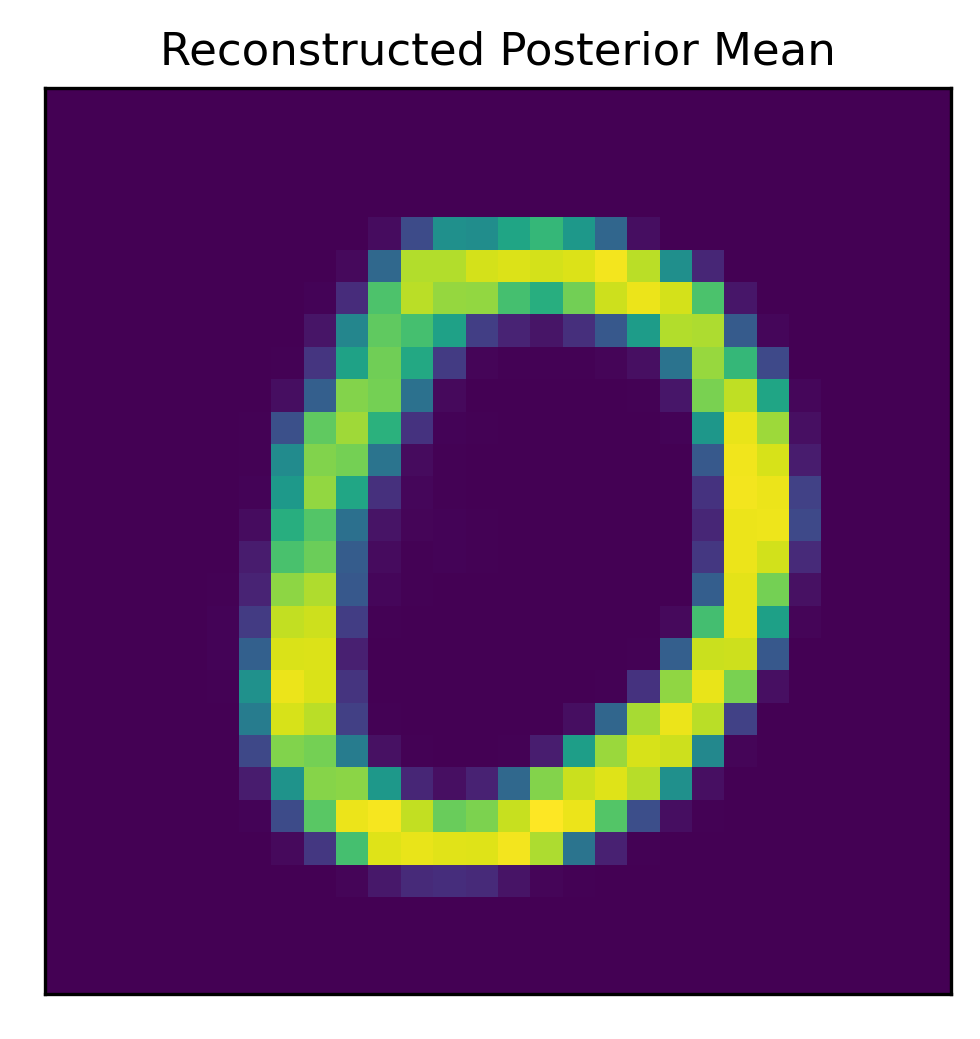

In [18]:
plt.imshow(np.reshape(Decoder(posterior_mean).val, [28, 28]))
clear_axis()
mpl.rcParams['figure.dpi']= 150
plt.title('Reconstructed Posterior Mean')

Text(0.5, 0.98, 'All 50 Samples drawn from Posterior Distribution')

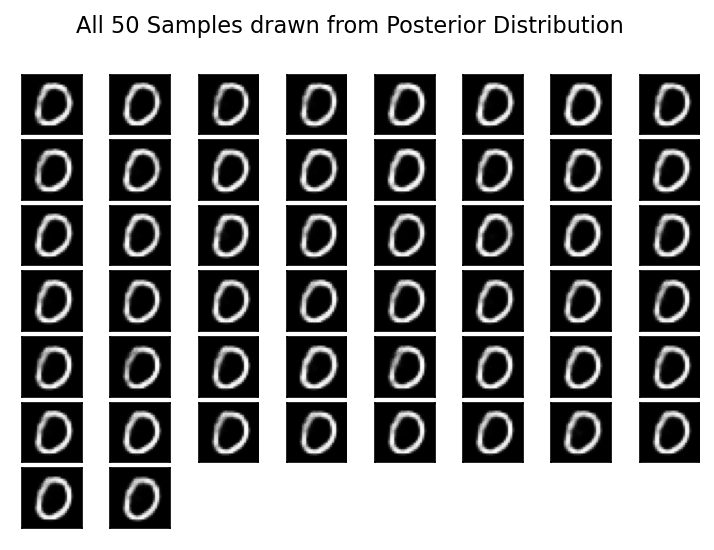

In [19]:
# Visualize reconstructions of all posterior samples. Output dependent on n_samples.

grid = plt.GridSpec(np.int(np.floor(np.sqrt(len(latent_posteriors)))), np.int(np.ceil(np.sqrt(len(latent_posteriors)))), wspace=0.1, hspace=0.1)
k=0
latent_posteriors=latent_posteriors[latent_posteriors[:,5].argsort()]
for i in range(np.int(np.floor(np.sqrt(len(latent_posteriors))))):
  for j in range(np.int(np.ceil(np.sqrt(len(latent_posteriors))))):
    if k < iters*n_samples:
      plt.subplot(grid[i, j])
      plt.imshow(np.reshape(Decoder(ift.Field.from_raw(latent_space, latent_posteriors[k, :])).val, img_shape), 'gray')
      clear_axis()
      k += 1
    else:
      break
fig = plt.gcf()
fig.suptitle("All {} Samples drawn from Posterior Distribution".format(len(latent_posteriors), fontsize=14))

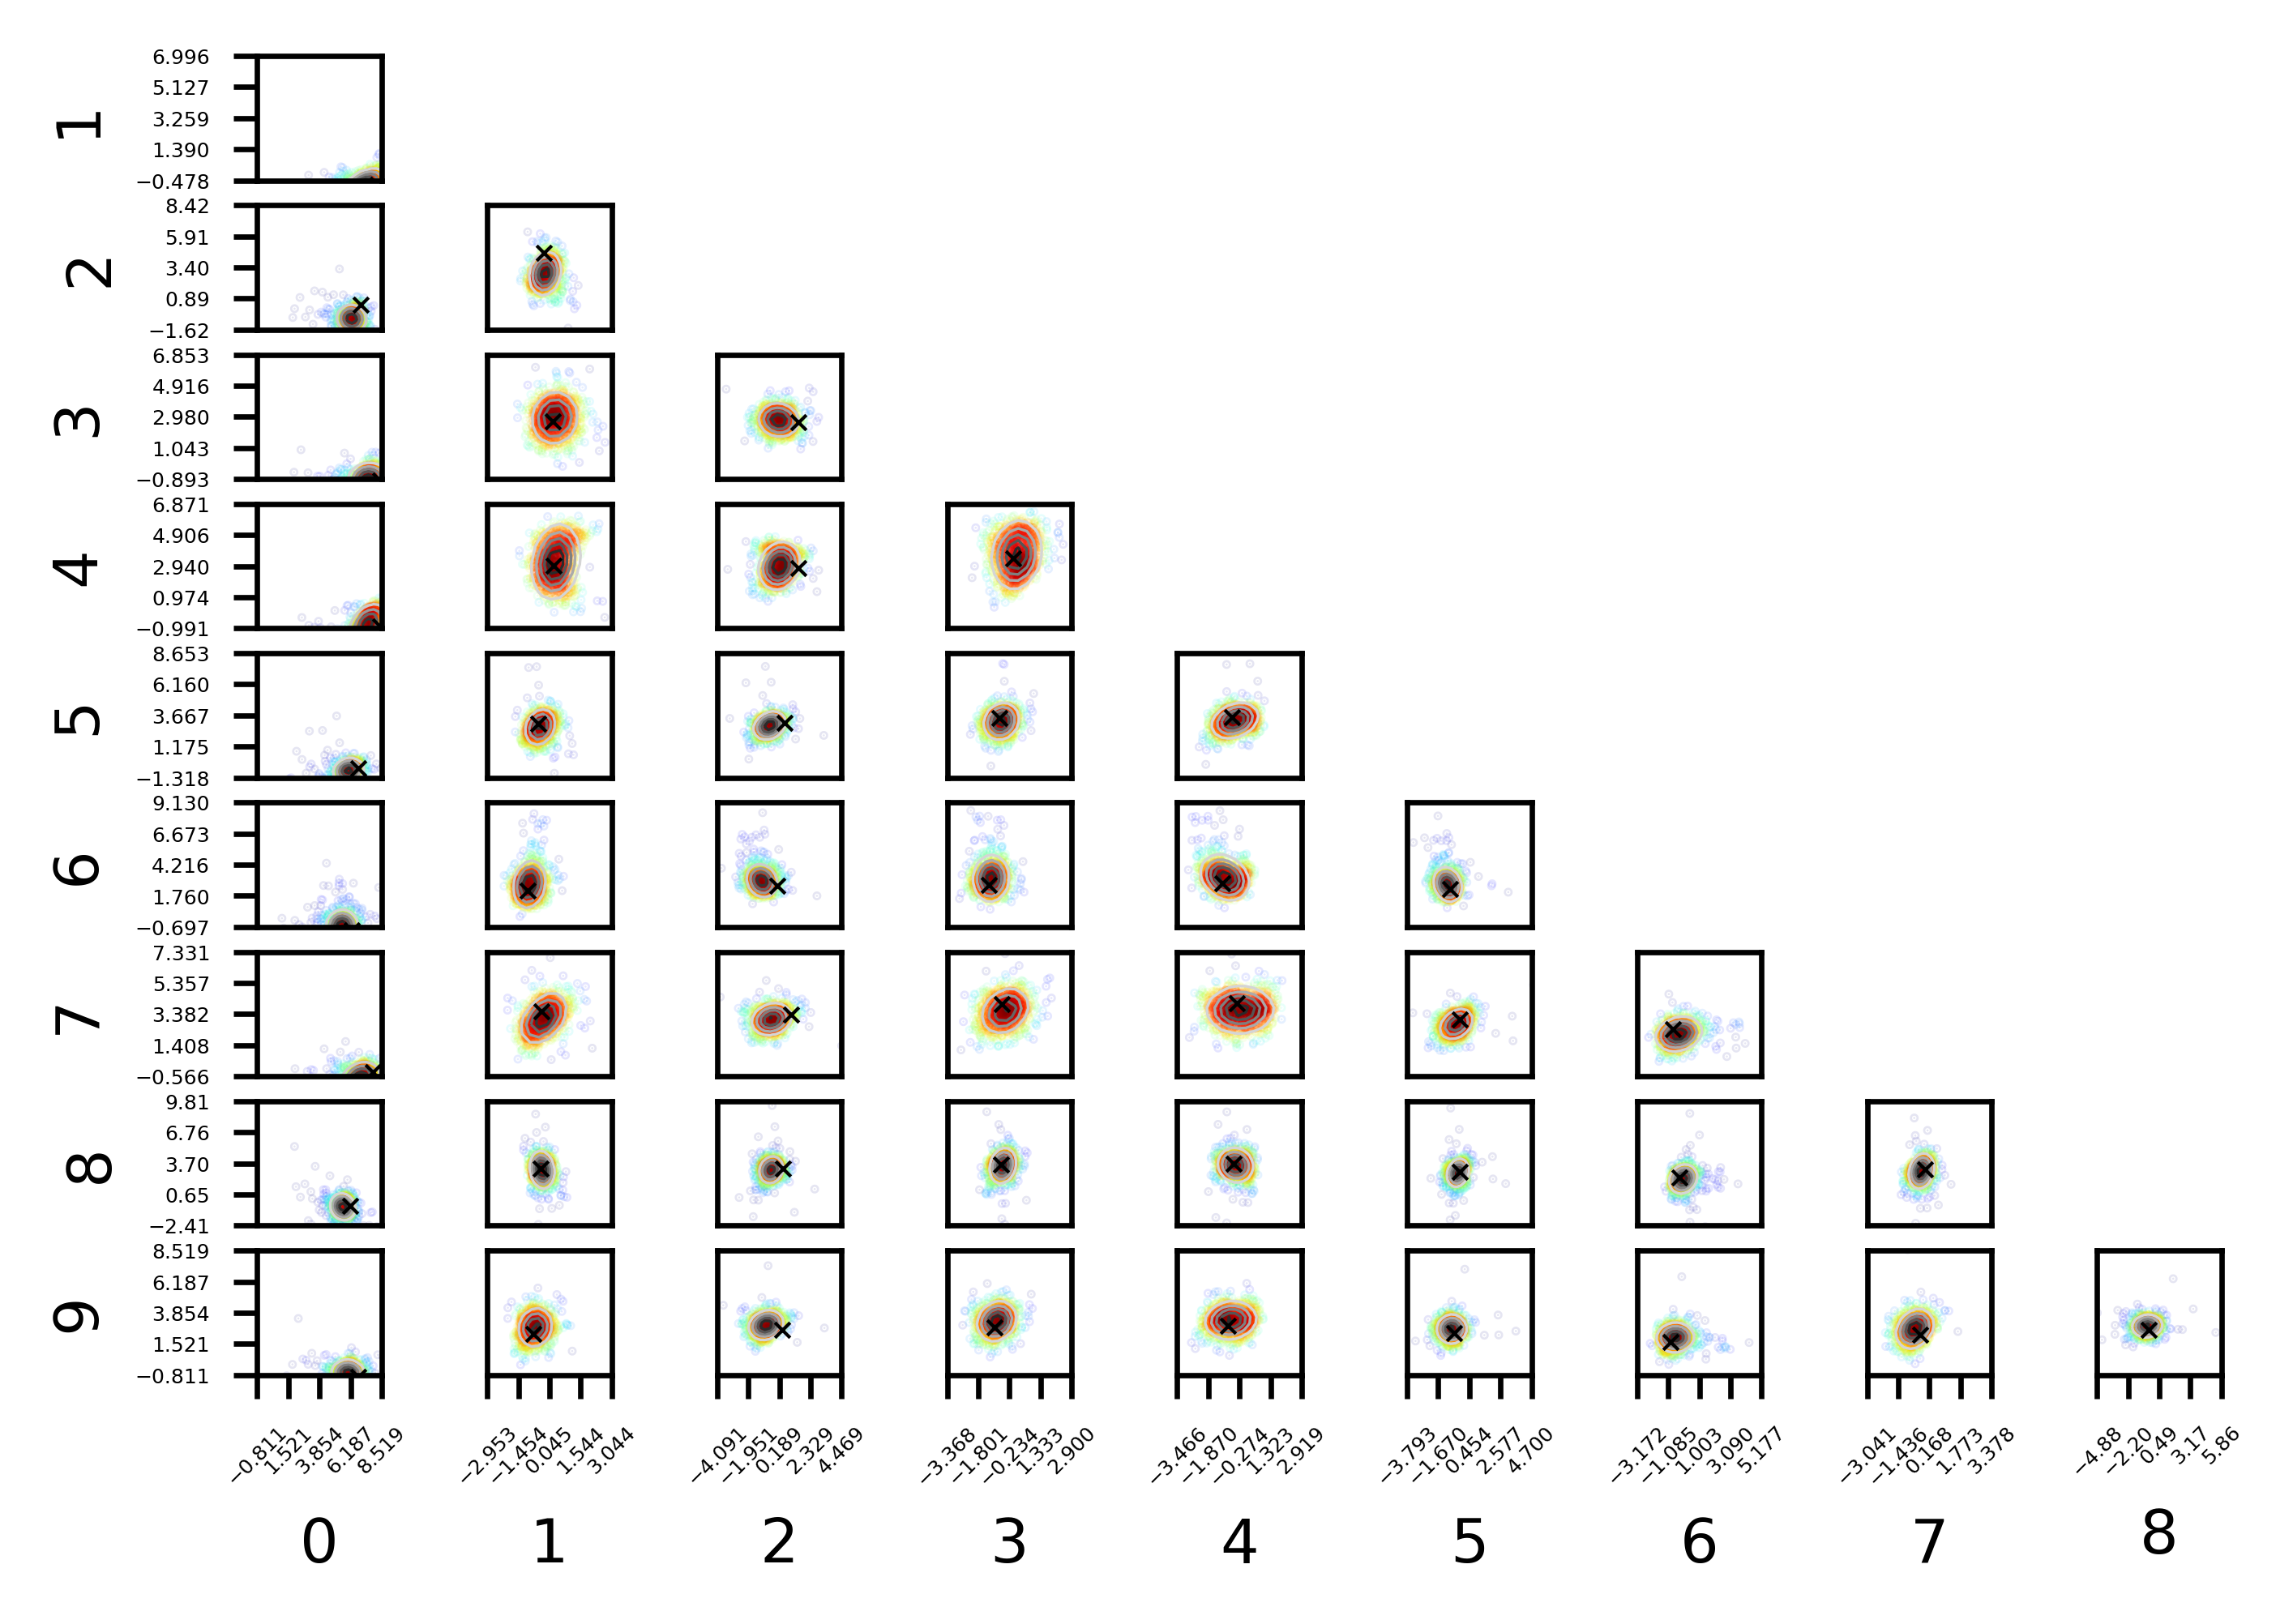

In [20]:
# Plot entire latent space and reconstructed latent space signal. 
# Set resolution of plot
mpl.rcParams['figure.dpi']= 600

classified_digit = np.where(mahalanobis_mean == mahalanobis_mean.min())[0]
if n_latent > 10:
  grid_resize = n_latent - 10
else:
  grid_resize = 0
def plot_covariances(hidden_rep, cov, mean):
    fig = plt.figure()
    for i in range(n_latent - grid_resize):
        for j in range(i, n_latent - grid_resize):
            if i == j:
                continue

            ## a ##
            ## Plot with respect to all samples in latent space
            #idx = random.sample(range(0, len(XVal)), len(XVal)//10)
            #cov_small = [[cov[i, i], cov[j, i]], [cov[i, j], cov[j, j]]]

            ## b ##
            # Plot only with respect to  classified digit (e.g. "all 9s in latent space")
            idx = np.where(YVal == classified_digit)
            cov_small = [[cov_all_variables[classified_digit[0]][i, i], cov_all_variables[classified_digit[0]][j, i]], [cov_all_variables[classified_digit[0]][i, j], cov_all_variables[classified_digit[0]][j, j]]]
            x = hidden_rep[:, i][idx]
            y = hidden_rep[:, j][idx]
            
            data = np.array([x, y])
            mu = np.mean(data, axis=1)

            # Plot samples in latent space from XTest with color respective to kernel density
            kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data.T)
            Z = kde.score_samples(data.T)
            ax = plt.subplot2grid((n_latent - grid_resize, n_latent - grid_resize), (j, i))
            ax.scatter(x, y, s=0.1, alpha=0.1, c=Z, cmap='jet')

            # Plot fitted gaussian
            X, Y = np.mgrid[hidden_rep.min():hidden_rep.max():100j, hidden_rep.min():hidden_rep.max():100j]
            pos = np.dstack((X, Y))
            rv = multivariate_normal(mu, cov_small)
            ax.contour(X, Y, rv.pdf(pos), 5, linewidths=0.4, cmap='gist_yarg')

            # Plot posterior mean
            
            ax.scatter(np.array(posterior_mean.val)[i], np.array(posterior_mean.val)[j], c='black', marker='x', s=5, linewidth=0.5, zorder=10)
            #ax.scatter(np.array(latent_posteriors)[:, i], np.array(latent_posteriors)[:, j], c='red', s=0.05, marker='x')
            ax.set_aspect('equal', adjustable='box')
            clear_axis()
            min = (np.min(x)+np.min(y))/1.5
            max=  (np.max(x)+np.max(y))/1.5

            ax.axes.set_ylim([min, max])
            ax.axes.set_xlim([min, max])

            if i == 0:
                ax.set_ylabel(j)
                ax.axes.yaxis.set_ticks(np.linspace(min, max, 5))
                plt.yticks(fontsize=3)
            if j == 9:
                ax.set_xlabel(i)
                ax.axes.xaxis.set_ticks(np.linspace(min, max, 5))
                plt.xticks(fontsize=3, rotation=45)

plot_covariances(latent_values, cov, mean.val)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


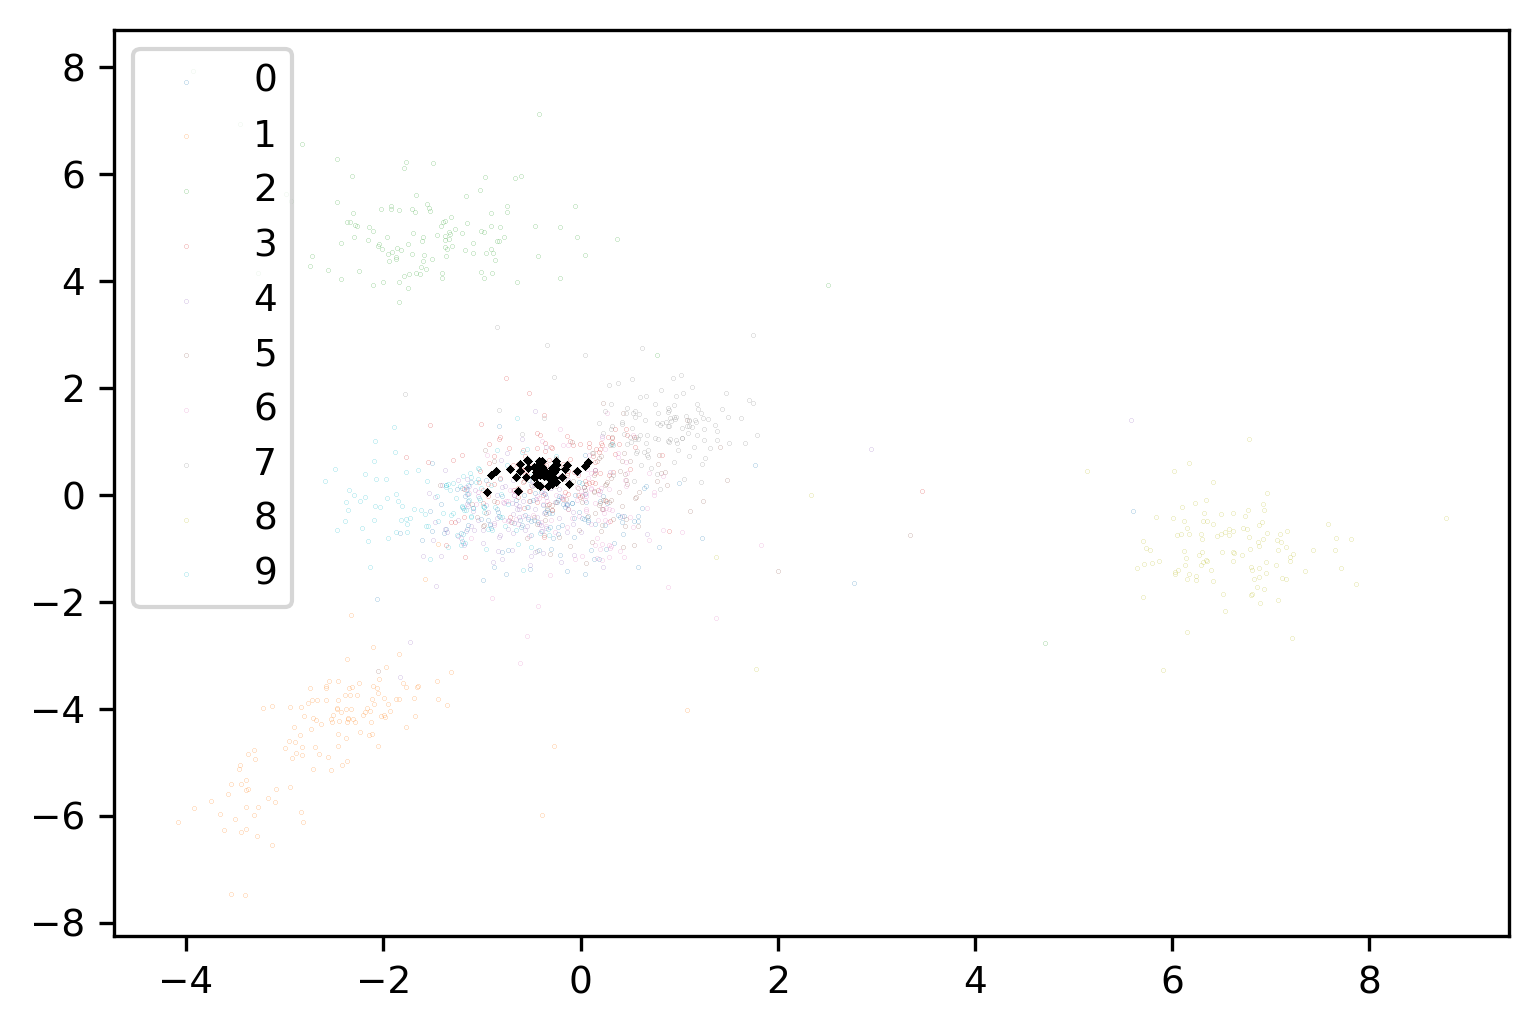

In [21]:
# Visualize reconstructed latent space with pca in comparison with latent space activations from Validation Data set. 


import csv
from google.colab import files
csv_data=[]
def plot_pca(Encoder, input_data):
    # Get latent space representation (predict samples up to 'bottleneck')
    hidden_rep = Encoder_tf.predict(input_data)

    # For visualization, compute PCA of latent space
    # pca = sk.decomposition.KernelPCA(n_components=10, kernel='linear')
    pca = sk.decomposition.PCA(n_components=10)
    principalComponents = pca.fit_transform(hidden_rep)
    labels = np.arange(0, 10, dtype=int)

    fig = plt.figure()
    ax = fig.add_subplot(111)#, projection='3d')
    digits = range(0, 10, 1)

    # Plot 3 strongest PCs
    for digit in digits:
        PC1 = principalComponents[np.where(YVal == digit), 0]
        PC2 = principalComponents[np.where(YVal == digit), 1]
        
        #PC3 = principalComponents[np.where(YTest == digit), 2]

        plot_indices = random.sample(range(0, len(PC1.T)), round(len(PC1.T) / 10))
        ax.scatter(PC1[:, plot_indices][0][:],
                   PC2[:, plot_indices][0][:], marker='.', s=0.01)
                   #PC3[:, plot_indices], label=digit)
        
        for x, y in zip(PC1[:, plot_indices][0][:], PC2[:, plot_indices][0][:]):
          csv_data.append([x, y, digit])
        with open('/content/drive/My Drive/masterthesis/data.csv', 'w') as csvfile:
          csvfile.write("x,y,label\n")
          spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='"', quoting=csv.QUOTE_MINIMAL)
          for datapoint in csv_data:
            spamwriter.writerow(datapoint)
    encoded_pca = pca.transform(latent_posteriors)
    ax.scatter(encoded_pca[:, 0], encoded_pca[:, 1], marker='x', s=1, c='black')

    plt.legend(labels)

# Plotting
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['font.size'] = 9.0
plot_pca(Encoder, XVal)
plt.show()